# Trading strategy

In [86]:
import requests

from pandas import json_normalize
from urllib.parse import urlencode

from typing import Dict, List, Union, Optional, Any
import warnings

warnings.filterwarnings("ignore")

Connect to Token Metrics Data API

In [87]:
API_key = ''

def tm_API(endpoint: str, payload: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """Obtain data from the Token Metrics Data API

    Args:
        endpoint (str): The endpoint of the API
        payload (Optional[Dict[str, Any]], optional): The parameters to send to the API. Defaults to None.

    Returns:
        Dict[str, Any]: The response from the API
    """

    if payload:
        url = 'https://alpha.data-api.tokenmetrics.com/v1/' + endpoint + '?' + urlencode(payload)
    else:
        url = 'https://alpha.data-api.tokenmetrics.com/v1/' + endpoint 
    headers = {'Accept': 'application/json', 'Content-Type': 'application/json', 'api_key': API_key}
    response = requests.get(url, headers=headers)
    return response.json()

Get Token Values

In [88]:
endpoint = 'tokens'
params = {}
response = tm_API(endpoint,params)
coins = json_normalize(response['data'])
coins = coins.sort_values(by = 'TOKEN_ID').reset_index(drop = True)
coins[coins.NAME.isin(['Bitcoin','XRP','Ethereum'])].reset_index(drop = True)

,TOKEN_ID,NAME,SYMBOL
0,3306,Ethereum,ETH
1,3369,XRP,XRP
2,3375,Bitcoin,BTC


Get price data from Binance

In [96]:
import pandas as pd
import datetime as dt
import requests

# Obtain data from the Binance US API
params = {'symbol': 'BTCUSDT', 
       'interval': '1d', 
       'startTime': int(dt.datetime(2020,5,2).timestamp())*1000,
       'endTime': int(dt.datetime(2023,1,28).timestamp())*1000,
       'limit': 1000}

r = requests.get('https://api.binance.us/api/v3/klines', params = params).json()

# Convert to pandas dataframe
col = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades',
       'Taker buy volume','Taker buy quote asset volume','Ignore']
btcusdt = pd.DataFrame(r, columns = col)

btcusdt['Open time'] = btcusdt['Open time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000)).dt.strftime('%Y-%m-%d')
btcusdt['Close time'] = btcusdt['Close time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000)).dt.strftime('%Y-%m-%d')

# Clean up the data
btcusdt.rename(columns = {'Close time': 'Date'}, inplace = True)
btcusdt[['Open', 'High', 'Low', 'Close', 'Volume']] = btcusdt[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
btcusdt = btcusdt[['Date','Open', 'High', 'Low', 'Close', 'Volume']]
btcusdt


,Date,Open,High,Low,Close,Volume
0,2020-05-03,8818.22,9014.77,8757.77,8972.68,59.469765
1,2020-05-04,8973.85,9196.27,8718.08,8887.35,210.049083
2,2020-05-05,8896.62,8954.26,8528.63,8868.92,198.322480
3,2020-05-06,8878.25,9105.20,8772.22,9027.64,133.862430
4,2020-05-07,9022.44,9396.16,8918.99,9145.93,242.577093
...,...,...,...,...,...,...
995,2023-01-23,22783.64,23074.91,22309.38,22714.51,3497.443376
996,2023-01-24,22710.87,23173.98,22514.16,22915.06,2640.997861
997,2023-01-25,22913.74,23157.50,22473.84,22631.85,2143.908361
998,2023-01-26,22639.70,23809.38,22340.00,23055.67,2197.009498


In [ ]:
Get Trader Grades from Token Metrics

In [97]:
endpoint = 'trader-grades'
params = {
    'tokens': '3375',
    'startDate': '2020-05-03T00:00:00.000Z',
    'endDate': '2023-01-27T00:00:00.000Z',
    'limit': 1000

}
r = tm_API(endpoint,params)
trader_grades = json_normalize(r['data'])

Merge with prices

In [125]:
# select the columns we want
btc_tg = trader_grades[['DATE','TA_GRADE','QUANT_GRADE','TM_TRADER_GRADE',]]

# merge the data
data = pd.merge(btc_tg, btcusdt, left_on='DATE', right_on='Date', how='left').drop('Date', axis=1)

# do some transformations
data['DayReturnPCT'] = (data.Close/data.Close.shift(-1) - 1)*100
data['ta_gradePCT'] = (data['TA_GRADE']/data['TA_GRADE'].shift(-1) - 1)*100
data['quant_gradePCT'] = (data['QUANT_GRADE']/data['QUANT_GRADE'].shift(-1) - 1)*100
data['tm_trader_gradePCT'] = (data['TM_TRADER_GRADE']/data['TM_TRADER_GRADE'].shift(-1) - 1)*100
data['DailyReturnPCT'] = (data.Close/data.Open - 1)*100
data['Range'] = data['High']-data['Low']
data['ATR'] = data['Range'].rolling(window = 5).mean()

In [126]:
data

,DATE,TA_GRADE,QUANT_GRADE,TM_TRADER_GRADE,Open,High,Low,Close,Volume,DayReturnPCT,ta_gradePCT,quant_gradePCT,tm_trader_gradePCT,DailyReturnPCT,Range,ATR
0,2023-01-27,96.508386,53.597822,87.926273,23071.15,23274.74,22858.60,23005.88,1193.341499,-0.215956,0.100519,-3.260350,-0.321669,-0.282907,416.14,NaN
1,2023-01-26,96.411474,55.404193,88.210018,22639.70,23809.38,22340.00,23055.67,2197.009498,1.872671,0.147988,-0.382008,0.081101,1.837348,1469.38,NaN
2,2023-01-25,96.269008,55.616653,88.138537,22913.74,23157.50,22473.84,22631.85,2143.908361,-1.235912,0.031941,0.746405,0.121549,-1.230223,683.66,NaN
3,2023-01-24,96.238269,55.204603,88.031536,22710.87,23173.98,22514.16,22915.06,2640.997861,0.882916,0.046219,-0.982395,-0.083961,0.899085,659.82,NaN
4,2023-01-23,96.193809,55.752311,88.105510,22783.64,23074.91,22309.38,22714.51,3497.443376,-0.269758,0.032281,0.339958,0.071115,-0.303419,765.53,798.906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2021-01-05,83.090496,55.044830,77.481363,33034.55,33593.47,27500.00,32005.27,987.279894,-3.107526,1.154633,0.088535,1.001774,-3.115768,6093.47,4815.846
753,2021-01-04,82.142057,54.996140,76.712873,32174.75,34776.59,31942.96,33031.74,701.951087,2.704215,-14.545953,3.055854,-12.400697,2.663548,2833.63,4308.602
754,2021-01-03,96.124244,53.365372,87.572470,29321.41,33271.38,28955.02,32162.01,667.482338,9.748138,0.040225,1.551148,0.221961,9.687802,4316.36,4262.854
755,2021-01-02,96.085594,52.550240,87.378523,28933.86,29611.51,28649.46,29305.29,298.357085,1.383725,0.149750,0.907083,0.240241,1.283721,962.05,3732.082


In [368]:
data['DailyReturnPCT'][data['TM_TRADER_GRADE'] > 75].mean()

0.9162547751161891

In [507]:
data['DailyReturnPCT'][data['TM_TRADER_GRADE'] < 25].mean()

-1.135746992300318

Apply trading strategy

In [506]:
START_VAL = 100000
strat_ret = [0] * len(data)
FADE_RANGE = [0.5, 0.75, 1.0] 
for index in range(len(data)):
    # print(data['TM_TRADER_GRADE'].iloc[index])
    costs = 0
    if data['TM_TRADER_GRADE'].loc[index] < 25:
        costs = 0.0008
        strat_ret[index] = -data['DailyReturnPCT'].iloc[index] / 100 
        #strat_ret[index] = 0
        
    elif data['TM_TRADER_GRADE'].loc[index] > 75:
        costs = 0.0008
        strat_ret[index] = data['DailyReturnPCT'].iloc[index] / 100 
        #strat_ret[index] = 0
        
    else:
        ave_range = data['Range'].iloc[index:index+9].mean()
        buy_op = []
        sell_op = []
        buy_cl = 0
        sell_cl = 0
        
        if data['Low'].iloc[index] < data['Open'].iloc[index] - FADE_RANGE[2] * ave_range:
            costs = costs + 0.0004
            buy_op.append(data['Open'].iloc[index] - FADE_RANGE[2] * ave_range)
        if data['Low'].iloc[index] < data['Open'].iloc[index] - FADE_RANGE[1] * ave_range:
            costs = costs + 0.0004
            buy_op.append(data['Open'].iloc[index] - FADE_RANGE[1] * ave_range)
        if data['Low'].iloc[index] < data['Open'].iloc[index] - FADE_RANGE[0] * ave_range:
            costs = costs + 0.0004
            buy_op.append(data['Open'].iloc[index] - FADE_RANGE[0] * ave_range)
            
        if data['High'].iloc[index] > data['Open'].iloc[index] + FADE_RANGE[2] * ave_range:
            costs = costs + 0.0004
            sell_op.append(data['Open'].iloc[index] + FADE_RANGE[2] * ave_range)
        if data['High'].iloc[index] > data['Open'].iloc[index] + FADE_RANGE[1] * ave_range:
            costs = costs + 0.0004
            sell_op.append(data['Open'].iloc[index] + FADE_RANGE[1] * ave_range)
        if data['High'].iloc[index] > data['Open'].iloc[index] + FADE_RANGE[0] * ave_range:
            costs = costs + 0.0004
            sell_op.append(data['Open'].iloc[index] + FADE_RANGE[0] * ave_range)
        
        if len(buy_op) < len(sell_op):
            buy_cl = (len(sell_op) - len(buy_op)) * data['Close'].iloc[index]
            costs = costs + (len(sell_op) - len(buy_op))*0.0004
        elif len(sell_op) < len(buy_op):
            sell_cl = (len(buy_op) - len(sell_op)) * data['Close'].iloc[index]
            costs = costs + (len(buy_op) - len(sell_op))*0.0004
        
        strat_ret[index] = (sell_cl + sum(sell_op) - buy_cl - sum(buy_op)) / data['Open'].iloc[index]
    
    strat_ret[index] = strat_ret[index] - costs
        
        
print("Average daily return: ",statistics.mean(strat_ret))


Average daily return:  0.004570649670386248


Calculate statistics and plot

<class 'list'>
Annualised return:  2.658909116317079
Annualised standard deviation:  0.8539178401456138
Downside deviation:  0.7527410282865914
Sharpe ratio:  3.113776280705964
Sortino  ratio:  3.47916350763862


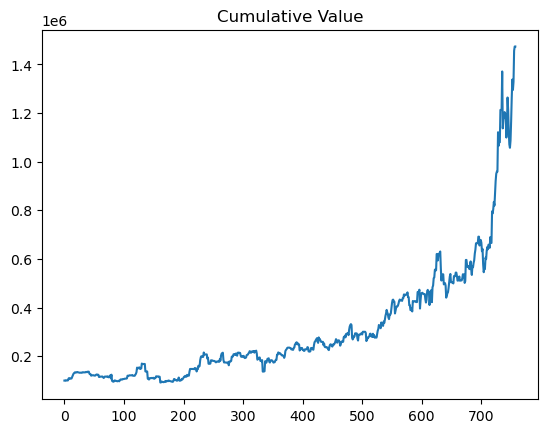

In [496]:
import statistics
from matplotlib import pyplot as plt


compound = 1
strat_value = [100000]
strat_ret.reverse()
neg_ret = []
for ret in strat_ret:
    compound = compound * (1 + ret)
    strat_value.append(compound * 100000)
    if ret < 0:
        neg_ret.append(ret)
    
plt.title("Cumulative Value")
plt.plot(strat_value)

#print(compound, len(strat_ret))
ave_ret = pow(compound, 365 / len(strat_ret)) - 1
print("Annualised return: ", ave_ret)
#ave_ret = statistics.mean(strat_ret)
std_ret = statistics.stdev(strat_ret) * statistics.sqrt(365)
neg_std_ret = statistics.stdev(neg_ret) * statistics.sqrt(365)

print("Annualised standard deviation: ", std_ret)
print("Downside deviation: ", neg_std_ret)
print("Sharpe ratio: ", ave_ret / std_ret)
print("Sortino  ratio: ", (ave_ret - 0.04) / neg_std_ret)

Calculate max drawdown

In [503]:
min_val = []
for index, value in enumerate(strat_value):
    if index > 0:
        min_val.append(value / max(strat_value[0:index])-1)

print("Maximum drawdown: ",min(min_val))


Maximum drawdown:  -0.4576243238712262
